In [2]:
pdb_ids = set()
with open("/home/qkrgangeun/LigMet/code/scripts/dataset/split/biolip/testset_filtered.tsv") as f:
    next(f)  # skip header
    for line in f:
        _, chain = line.strip().split()
        pdb_id = chain.split(":")[0]
        pdb_ids.add(pdb_id)

print(pdb_ids)
print(len(pdb_ids))

{'8gft', '8so0', '8eup', '7tbq', '8f9x', '8iue', '7w51', '8iun', '8ei5', '8hxy', '8qf5', '8ted', '7zmw', '8izm', '8bed', '8ch4', '7usy', '7t0y', '8dq6', '8cns', '8em4', '7xca', '8jp8', '7qpi', '8jar', '8bad', '8sff', '8bz7', '8shd', '8eaz', '7yvs', '7qp1', '8k9f', '8acu', '8au6', '8ohy', '8eoe', '8b5w', '8hy0', '7yr9', '7sie', '7y5q', '8eos', '8tug', '7z6q', '7yf6', '8p66', '8bbt', '8a30', '8eb0', '8qfp', '8jwj', '8dau', '8adl', '8ihn', '8q66', '8ic6', '7ym0', '8u2q', '7zak', '8imy', '8gyx', '8wqa', '7wtz', '8hil', '8ej3', '8q43', '7zs2', '8oi9', '8q3b', '7yi0', '7r72', '8ceu', '7wyg', '8avz', '8dqr', '8p39', '8fjn', '8hn9', '8ok9', '7yo3', '8squ', '7yi3', '8rbz', '8ito', '8pe9', '8srx', '8ep4', '8gyr', '8oel', '8gao', '8fvu', '8j7w', '7qux', '8q6o', '7y9g', '8j48', '7ong', '8qfq', '8djf', '7sjk', '8e9h', '7xxf', '8bz8', '8hhm', '8etg', '8v14', '8eho', '8c0w', '8d2q', '8i6r', '7f06', '8oev', '7zmg', '7wu0', '7urp', '8dg5', '7xr7', '8csu', '8e0q', '7tfk', '8b1n', '8pr4', '8wy5', '8jun',

In [3]:
input_path = "/home/qkrgangeun/LigMet/code/scripts/dataset/split/biolip/testset_filtered.tsv"
output_path = "/home/qkrgangeun/metal-site-prediction/Metal3D/test_pdb.txt"

pdb_ids = set()

with open(input_path, "r") as f:
    next(f)  # 헤더 건너뜀
    for line in f:
        _, chain = line.strip().split()
        pdb_id = chain.split(":")[0]
        pdb_ids.add(pdb_id)

with open(output_path, "w") as out_f:
    for pdb_id in sorted(pdb_ids):
        out_f.write(f"{pdb_id}\n")


In [ ]:
import os
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
import argparse

def compute_precision_recall(predicted_coords, true_coords, dist_threshold=2.0):
    # if len(predicted_coords) == 0:
    #     return 0.0, 0.0 if len(true_coords) > 0 else (1.0, 1.0)
    
    tp = 0
    fp = 0
    matched_true = []

    for pred_coord in predicted_coords:
        distances = np.linalg.norm(true_coords - pred_coord, axis=1)
        if np.any(distances < dist_threshold):
            tp += 1
            matched_true.append(np.argmin(distances))
        else:
            fp += 1

    fn = len(true_coords) - len(set(matched_true))
    precision = tp / (tp + fp) if (tp + fp) > 0 else -1.0 #아예제외시켜야할지? oo
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

def dbscan_clustering(coords, preds, eps=2.0, min_samples=1, method='max'):
    if len(coords) == 0:
        return np.array([]), np.array([])

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_
    unique_labels = set(labels)
    representatives = []

    for label in unique_labels:
        if label == -1:
            continue
        indices = np.where(labels == label)[0]
        if method == 'max':
            best_idx = indices[np.argmax(preds[indices])]
            representatives.append(coords[best_idx])
        elif method == 'mean':
            cluster_mean = np.mean(coords[indices], axis=0)
            representatives.append(cluster_mean)
        else:
            raise ValueError("method must be 'max' or 'mean'")

    return np.array(representatives), labels

def main(pdb_id, score_threshold):
    result_path = f"/home/qkrgangeun/LigMet/data/biolip/test/0526/test_last_{pdb_id}.npz"
    if not os.path.exists(result_path):
        print(f"[!] File not found: {result_path}")
        return None, None

    data = np.load(result_path, allow_pickle=True)

    metal_positions = data['metal_positions']
    grid_positions = data['grid_positions']
    grid_predictions = data['pred']
    grid_types = data['pred_types']
    mask = grid_predictions >= score_threshold
    selected_positions = grid_positions[mask]
    selected_preds = grid_predictions[mask]

    rep_positions, _ = dbscan_clustering(selected_positions, selected_preds, eps=2.0, min_samples=2, method='max')
    precision, recall = compute_precision_recall(rep_positions, metal_positions, dist_threshold=2.0)

    # print(f"[{pdb_id}] Precision: {precision:.3f}, Recall: {recall:.3f}")
    return precision, recall


def main2(pdb_id, score_threshold):
    """mask nontype grids
    """
    result_path = f"/home/qkrgangeun/LigMet/data/biolip/test/0526/test_last_{pdb_id}.npz"
    if not os.path.exists(result_path):
        print(f"[!] File not found: {result_path}")
        return None, None

    data = np.load(result_path, allow_pickle=True)

    metal_positions = data['metal_positions']
    grid_positions = data['grid_positions']
    grid_predictions = data['pred']  # shape: (n_grids,)
    grid_types = data['pred_types']  # shape: (n_grids, n_metal)

    # 1차 마스킹: score threshold 기준
    mask = grid_predictions >= score_threshold
    selected_positions = grid_positions[mask]
    selected_preds = grid_predictions[mask]
    selected_types = grid_types[mask]  # shape: (n_selected, n_metal)

    # 2차 마스킹: top-1이 nontype(마지막 index)가 아닌 것만
    top1_indices = np.argmax(selected_types, axis=1)
    is_not_nontype = top1_indices != (selected_types.shape[1] - 1)

    selected_positions2 = selected_positions[is_not_nontype]
    selected_preds2 = selected_preds[is_not_nontype]

    rep_positions, _ = dbscan_clustering(selected_positions2, selected_preds2, eps=2.0, min_samples=2, method='max')
    precision, recall = compute_precision_recall(rep_positions, metal_positions, dist_threshold=2.0)

    return precision, recall


def run_batch(pdb_list, score_threshold):
    precisions = []
    recalls = []
    
    for pdb_id in pdb_list:
        precision, recall = main(pdb_id.strip(), score_threshold)
        if precision is not None and recall is not None:
            precisions.append(precision)
            recalls.append(recall)

    if precisions:
        precisions = np.array(precisions)
        valid = precisions[precisions != -1]
        mean_precision = float(np.mean(valid)) if len(valid) > 0 else -1.0
        
        mean_recall = np.mean(recalls)
        print(f"\n==>Threshold:{score_threshold} Mean Precision: {mean_precision:.3f}, Mean Recall: {mean_recall:.3f}")

    else:
        print("[!] No valid results.")
    return mean_precision, mean_recall




In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_curve(score_thresholds, precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o', label='PR Curve')
    for i, thresh in enumerate(score_thresholds):
        if i % 10 == 0:
            plt.annotate(f'{thresh:.1f}', (recalls[i], precisions[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve vs Score Threshold')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 실행 예시:
# score_thresholds = np.linspace(0.1, 0.9, 9)
# precisions = [...]
# recalls = [...]
# plot_precision_recall_curve(score_thresholds, precisions, recalls)



==> Running with score threshold: 0.01

==>Threshold:0.01 Mean Precision: 0.153, Mean Recall: 0.861

==> Running with score threshold: 0.02

==>Threshold:0.02 Mean Precision: 0.195, Mean Recall: 0.856

==> Running with score threshold: 0.03

==>Threshold:0.03 Mean Precision: 0.220, Mean Recall: 0.851

==> Running with score threshold: 0.04

==>Threshold:0.04 Mean Precision: 0.237, Mean Recall: 0.848

==> Running with score threshold: 0.05

==>Threshold:0.05 Mean Precision: 0.252, Mean Recall: 0.844

==> Running with score threshold: 0.06

==>Threshold:0.060000000000000005 Mean Precision: 0.268, Mean Recall: 0.843

==> Running with score threshold: 0.07

==>Threshold:0.06999999999999999 Mean Precision: 0.280, Mean Recall: 0.842

==> Running with score threshold: 0.08

==>Threshold:0.08 Mean Precision: 0.289, Mean Recall: 0.840

==> Running with score threshold: 0.09

==>Threshold:0.09 Mean Precision: 0.301, Mean Recall: 0.839

==> Running with score threshold: 0.10

==>Threshold:0.0999

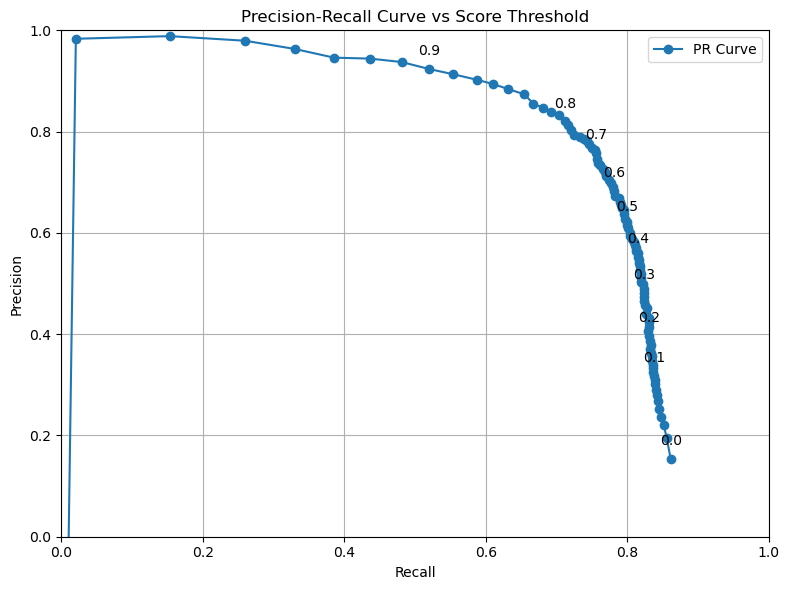

In [41]:
with open("/home/qkrgangeun/LigMet/data/biolip/pdb/test_pdb_noerror.txt", 'r') as f:
    pdb_list = [line.strip() for line in f if line.strip()]

score_thresholds = np.linspace(0.01, 0.99, 99)
all_precisions = []
all_recalls = []

for score_threshold in score_thresholds:
    print(f"\n==> Running with score threshold: {score_threshold:.2f}")
    precisions, recalls = run_batch(pdb_list, score_threshold)
    all_precisions.append(precisions)
    all_recalls.append(recalls)
print(len(all_precisions), len(all_recalls))
plot_precision_recall_curve(score_thresholds, all_precisions, all_recalls)


In [17]:
print(score_thresholds)
print(all_precisions)
print(all_recalls)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[[0.16666666666666666, 0.125, 0.2857142857142857, 0.0, 0.4634146341463415, 0.3333333333333333, 0.4, 1.0, 1.0, 0.5, 1.0, 0.058823529411764705, 0.1, 0.6666666666666666, 0.6666666666666666, 0.375, 0.5, 0.32, 0.6666666666666666, 0.45454545454545453, 0.07407407407407407, 0.15384615384615385, 0.1, 0.2, 0.2, 0.1935483870967742, 0.1724137931034483, 0.19230769230769232, 1.0, 0.3333333333333333, 0.0625, 0.16666666666666666, 0.2, 0.25806451612903225, 0.4, 0.6666666666666666, 0.42857142857142855, 0.5, 0.2222222222222222, 1.0, 1.0, 0.5, 0.25, 0.4, 0.2857142857142857, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.3076923076923077, 0.6666666666666666, 0.058823529411764705, 0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 0.2916666666666667, 0.034482758620689655, 0.125, 0.07142857142857142, 0.0, 0.1111111111111111, 0.05263157894736842, 0.05263157894736842, 0.1111111111111111, 0.5, 0.03333333333333333, 0.058823529411764705, 1.0, 0.5714285714285714, 0.33

Type

In [62]:
import os
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cdist
from ligmet.utils.constants import metals

def evaluate_single_pdb(pdb_id, score_threshold=0.5, top_k=1, dist_threshold=2.0):
    result_path = f"/home/qkrgangeun/LigMet/data/biolip/test/0526/test_last_{pdb_id}.npz"
    if not os.path.exists(result_path):
        print(f"[!] File not found: {result_path}")
        return [], []

    data = np.load(result_path, allow_pickle=True)

    metal_positions = data['metal_positions']          # (N_metal, 3)
    metal_types = data['metal_types']                  # (N_metal,)
    grid_positions = data['grid_positions']            # (N_grid, 3)
    grid_predictions = data['pred']                    # (N_grid,)
    grid_type_probs = data['type_pred']                # (N_grid, 10)

    # Threshold filtering
    mask = grid_predictions >= score_threshold
    filtered_positions = grid_positions[mask]
    filtered_type_probs = grid_type_probs[mask]

    if len(filtered_positions) == 0:
        return [], []

    dists = cdist(metal_positions, filtered_positions)  # (N_metal, N_selected_grid)
    closest_idx = np.argmin(dists, axis=1)
    closest_dist = np.min(dists, axis=1)

    predictions = []
    labels = []

    for i, (true_type, dist) in enumerate(zip(metal_types, closest_dist)):
        if dist <= dist_threshold:
            pred_probs = filtered_type_probs[closest_idx[i]]
            topk_pred_indices = np.argsort(pred_probs)[::-1][:top_k]
        else:
            topk_pred_indices = []  # empty → will be treated as incorrect

        predictions.append((true_type, topk_pred_indices))
        labels.append(true_type)

    return predictions, labels



def compute_topk_accuracy(predictions, labels, top_k=1):
    correct_by_type = defaultdict(int)
    total_by_type = defaultdict(int)
    total_correct = 0

    for (true_idx, topk_pred), label in zip(predictions, labels):
        total_by_type[label] += 1
        if label in topk_pred:
            correct_by_type[label] += 1
            total_correct += 1

    # Compute overall accuracy
    total_samples = len(labels)
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    # Compute per-class accuracy
    per_class_accuracy = {
        metals[k]: correct_by_type[k] / total_by_type[k] if total_by_type[k] > 0 else 0.0
        for k in total_by_type
    }

    return overall_accuracy, per_class_accuracy


def type_batch(pdb_list, score_threshold=0.5, top_k=1):
    all_predictions = []
    all_labels = []

    for pdb_id in pdb_list:
        preds, lbls = evaluate_single_pdb(pdb_id, score_threshold, top_k)
        all_predictions.extend(preds)
        all_labels.extend(lbls)

    overall_acc, per_class_acc = compute_topk_accuracy(all_predictions, all_labels, top_k)

    print(f"\n[🔎 Evaluation Results | Top-{top_k} | Score threshold = {score_threshold}]")
    print(f"Overall Accuracy: {overall_acc:.4f}")
    print("\n[Per-metal Accuracy]")
    from collections import Counter
    type_counts = Counter(all_labels)
    
    for metal, acc in per_class_acc.items():
        count = type_counts[metals.index(metal)]
        print(f"{metal}: {acc:.4f} (n={count})")


In [66]:
with open("/home/qkrgangeun/LigMet/data/biolip/pdb/test_pdb_noerror.txt", 'r') as f:
    pdb_list = [line.strip() for line in f if line.strip()]
type_batch(pdb_list, score_threshold=0.5, top_k=1)


[🔎 Evaluation Results | Top-1 | Score threshold = 0.5]
Overall Accuracy: 0.7492

[Per-metal Accuracy]
MG: 0.5738 (n=427)
CA: 0.7706 (n=680)
ZN: 0.8774 (n=1509)
CU: 0.7500 (n=28)
MN: 0.1757 (n=148)
FE: 0.2889 (n=90)
CO: 0.0000 (n=5)
NI: 0.0000 (n=4)


metal type precision, recall curve

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from ligmet.utils.constants import metals

def gather_classwise_scores(pdb_list):
    """
    모든 pdb의 grid-level prediction에서 각 metal type에 대한
    [true_label, predicted_prob] 목록을 모읍니다.
    """
    all_true = {i: [] for i in range(len(metals))}  # class index: list of [y_true]
    all_scores = {i: [] for i in range(len(metals))}  # class index: list of predicted prob

    for pdb_id in pdb_list:
        result_path = f"/home/qkrgangeun/LigMet/data/biolip/test/0526/test_last_{pdb_id}.npz"
        if not os.path.exists(result_path):
            continue

        data = np.load(result_path, allow_pickle=True)
        metal_positions = data['metal_positions']
        metal_types = data['metal_types']
        grid_positions = data['grid_positions']
        pred_scores = data['pred']         # (N_grid,)
        type_probs = data['type_pred']     # (N_grid, 10)

        # For each metal point, get closest grid
        from scipy.spatial.distance import cdist
        dists = cdist(metal_positions, grid_positions)
        closest_idxs = np.argmin(dists, axis=1)

        for metal_type, idx in zip(metal_types, closest_idxs):
            class_idx = metal_type
            for k in range(len(metals)):
                all_true[k].append(1 if k == class_idx else 0)
                all_scores[k].append(type_probs[idx][k])

    return all_true, all_scores


def plot_precision_recall_curves_with_thresholds(pdb_list):
    all_true, all_scores = gather_classwise_scores(pdb_list)
    thresholds_to_mark = np.round(np.arange(0.1, 1.0, 0.1), 2)

    plt.figure(figsize=(10, 8))

    for class_idx in range(len(metals)):
        y_true = np.array(all_true[class_idx])
        y_score = np.array(all_scores[class_idx])

        if np.sum(y_true) == 0:
            continue

        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        plt.plot(recall, precision, label=metals[class_idx])

        # Threshold 위치 표시
        for t in thresholds_to_mark:
            idx = np.argmin(np.abs(thresholds - t))
            if idx < len(precision):  # 안전 확인
                plt.plot(recall[idx], precision[idx], 'o', markersize=4, label=f"{metals[class_idx]} @t={t:.1f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve per Metal Type (w/ Threshold Markers)")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_41830/1650509882.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


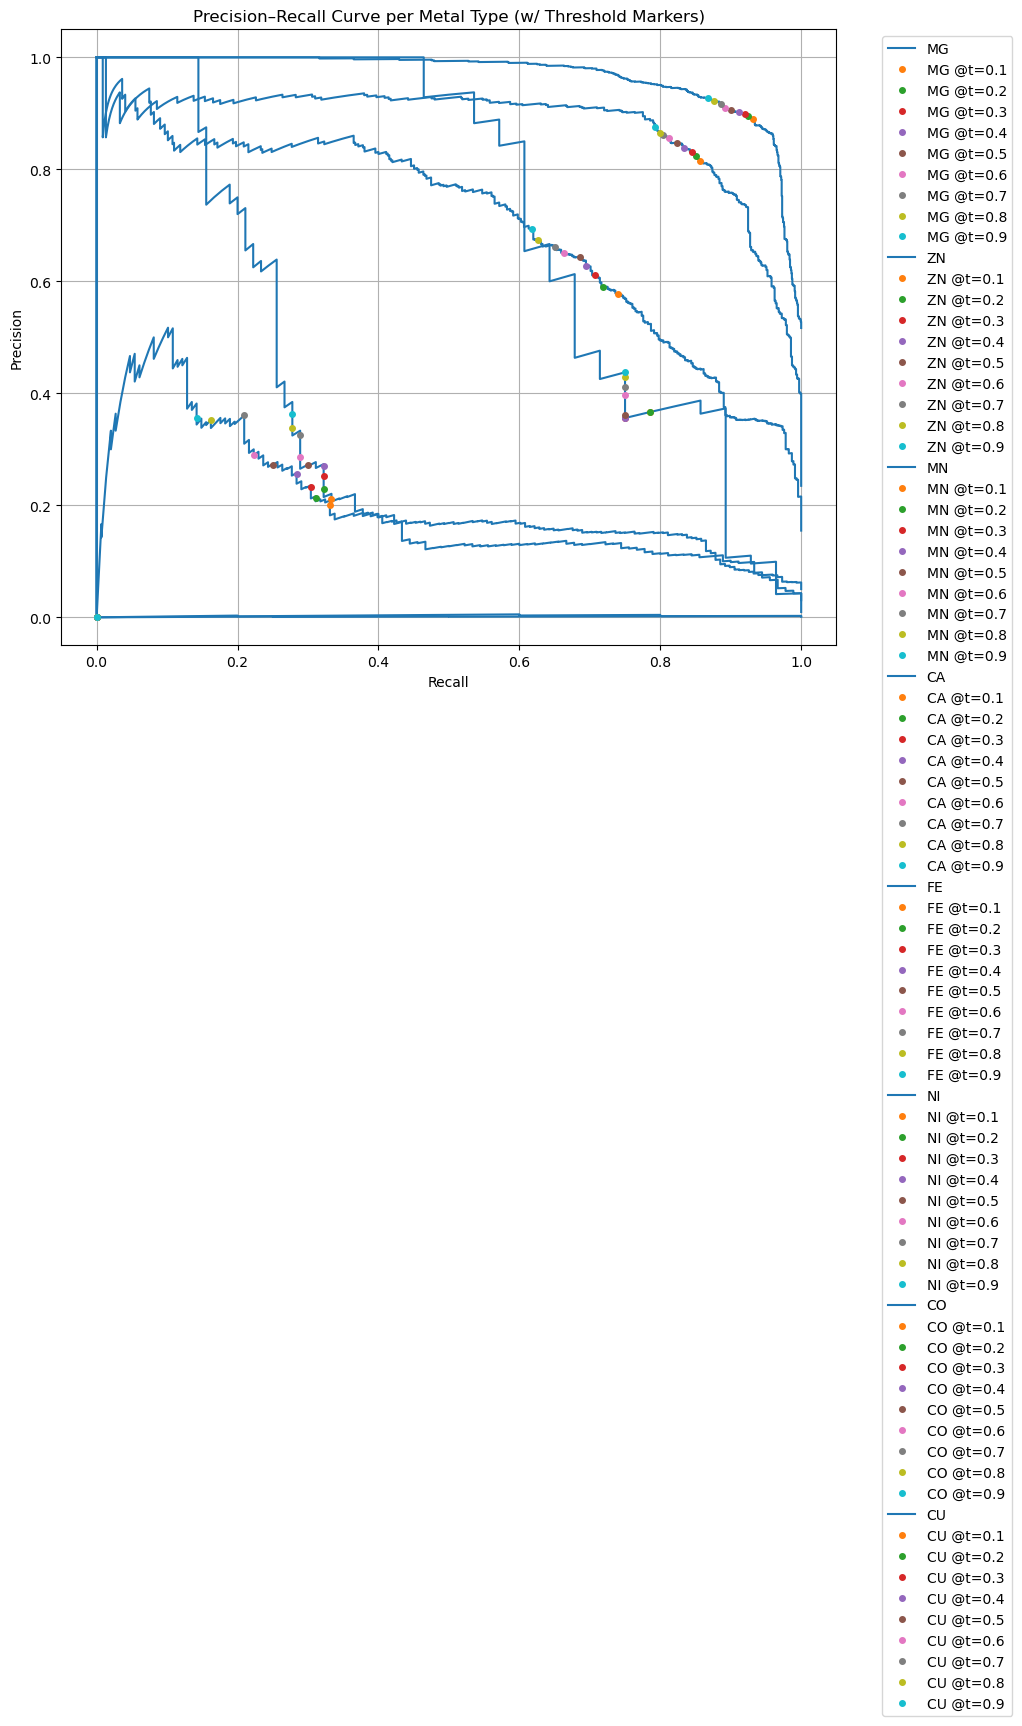

In [75]:
plot_precision_recall_curves_with_thresholds(pdb_list)

TH: 0.01 TP: 2491 FP: 24292 FN: 447 → Precision: 0.093, Recall: 0.848
TH: 0.02 TP: 2485 FP: 18023 FN: 453 → Precision: 0.121, Recall: 0.846
TH: 0.03 TP: 2479 FP: 15279 FN: 459 → Precision: 0.140, Recall: 0.844
TH: 0.04 TP: 2470 FP: 13646 FN: 468 → Precision: 0.153, Recall: 0.841
TH: 0.05 TP: 2466 FP: 12518 FN: 472 → Precision: 0.165, Recall: 0.839
TH: 0.06 TP: 2463 FP: 11569 FN: 475 → Precision: 0.176, Recall: 0.838
TH: 0.07 TP: 2463 FP: 10897 FN: 475 → Precision: 0.184, Recall: 0.838
TH: 0.08 TP: 2460 FP: 10306 FN: 478 → Precision: 0.193, Recall: 0.837
TH: 0.09 TP: 2458 FP: 9765 FN: 480 → Precision: 0.201, Recall: 0.837
TH: 0.10 TP: 2454 FP: 9293 FN: 484 → Precision: 0.209, Recall: 0.835
TH: 0.11 TP: 2454 FP: 8873 FN: 484 → Precision: 0.217, Recall: 0.835
TH: 0.12 TP: 2452 FP: 8467 FN: 486 → Precision: 0.225, Recall: 0.835
TH: 0.13 TP: 2450 FP: 8157 FN: 488 → Precision: 0.231, Recall: 0.834
TH: 0.14 TP: 2448 FP: 7818 FN: 490 → Precision: 0.238, Recall: 0.833
TH: 0.15 TP: 2449 FP: 7528

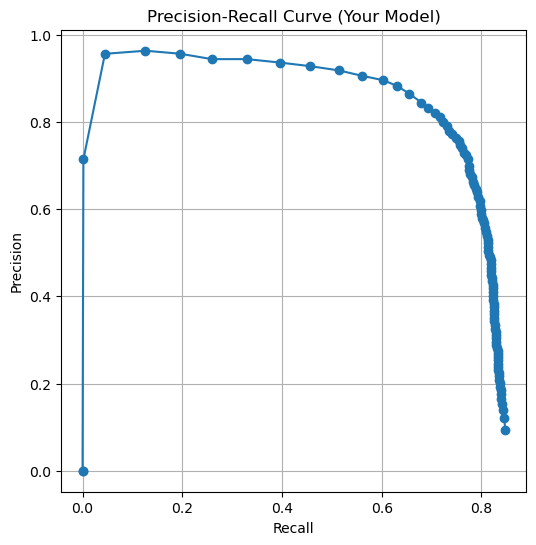

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 설정
pdb_list_file = "/home/qkrgangeun/LigMet/data/biolip/pdb/test_pdb_noerror.txt"
result_dir = "/home/qkrgangeun/LigMet/data/biolip/test/0526"
distance_threshold = 2.0  # Å
thresholds = np.linspace(0.01, 1.00, 100)
precision_list = []
recall_list = []

# DBSCAN 클러스터링 함수
def dbscan_clustering(coords, preds, eps=2.0, min_samples=1, method='max'):
    if len(coords) == 0:
        return np.array([]), np.array([])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_
    unique_labels = set(labels)
    representatives = []

    for label in unique_labels:
        if label == -1:
            continue
        indices = np.where(labels == label)[0]
        if method == 'max':
            best_idx = indices[np.argmax(preds[indices])]
            representatives.append(coords[best_idx])
        elif method == 'mean':
            cluster_mean = np.mean(coords[indices], axis=0)
            representatives.append(cluster_mean)
        else:
            raise ValueError("method must be 'max' or 'mean'")
    return np.array(representatives), labels

# 정밀도 및 재현율 계산 함수
def compute_precision_recall(pred_coords, true_coords, dist_threshold=2.0):
    if len(pred_coords) == 0:
        return 0, 0, len(true_coords)
    matched_true = set()
    tp = 0
    fp = 0
    for pred in pred_coords:
        distances = np.linalg.norm(true_coords - pred, axis=1)
        min_idx = np.argmin(distances)
        min_dist = distances[min_idx]
        if min_dist <= dist_threshold and min_idx not in matched_true:
            tp += 1
            matched_true.add(min_idx)
        else:
            fp += 1
    fn = len(true_coords) - len(matched_true)
    return tp, fp, fn

# PDB 목록 불러오기
with open(pdb_list_file, "r") as f:
    pdb_ids = [line.strip().lower() for line in f if line.strip()]

# Threshold loop
for threshold in thresholds:
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for pdb_id in pdb_ids:
        result_path = os.path.join(result_dir, f"test_last_{pdb_id}.npz")
        if not os.path.exists(result_path):
            continue

        data = np.load(result_path, allow_pickle=True)
        metal_positions = data['metal_positions']
        grid_positions = data['grid_positions']
        grid_predictions = data['pred']

        # threshold 적용 및 DBSCAN
        mask = grid_predictions >= threshold
        num_grid = len(grid_positions) - len(metal_positions)
        mask = grid_predictions >= threshold
        mask2 = np.zeros_like(mask, dtype=bool)
        mask2[:num_grid] = True  # 앞쪽 grid만 True
        final_mask = mask & mask2

        selected_positions = grid_positions[final_mask]
        selected_preds = grid_predictions[final_mask]

        rep_positions, _ = dbscan_clustering(
            selected_positions, selected_preds, eps=2.0, min_samples=2, method='max'
        )

        tp, fp, fn = compute_precision_recall(rep_positions, metal_positions, distance_threshold)
        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    precision_list.append(precision)
    recall_list.append(recall)

    print(f"TH: {threshold:.2f} TP: {total_tp} FP: {total_fp} FN: {total_fn} → Precision: {precision:.3f}, Recall: {recall:.3f}")

# Precision-Recall Curve Plot
plt.figure(figsize=(6, 6))
plt.plot(recall_list, precision_list, marker='o', linewidth=1.5)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Your Model)")
plt.grid(True)
plt.show()


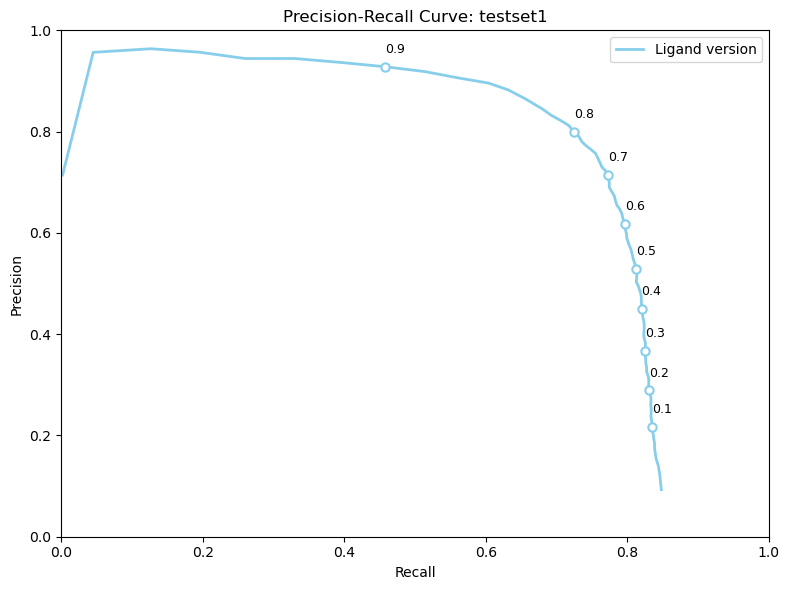

In [8]:
plt.figure(figsize=(8, 6))

# 전체 선은 marker 없이 그리기
plt.plot(recall_list, precision_list, color='skyblue', linewidth=2, label="Ligand version")

# threshold가 0.1 단위일 때만 마커 표시
for i, threshold in enumerate(thresholds):
    if i % 10 == 0 and i !=  0:
        plt.plot(
            recall_list[i], precision_list[i],
            marker='o',
            markersize=6,
            markerfacecolor='white',
            markeredgecolor='skyblue',
            markeredgewidth=1.5
        )
        plt.annotate(f"{threshold:.1f}", (recall_list[i], precision_list[i]),
                     textcoords="offset points", xytext=(0, 10), ha='left', fontsize=9)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: testset1")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import auc

# 파일 경로 설정
pdb_list_file = "/home/qkrgangeun/LigMet/data/biolip/pdb/test_pdb_noerror.txt"
metal3d_label_dir = "/home/qkrgangeun/LigMet/data/biolip/metal_label"
metal3d_prediction_dir = "/home/qkrgangeun/metal-site-prediction/Metal3D/result"
ligand_result_dir = "/home/qkrgangeun/LigMet/data/biolip/test/0526"

distance_threshold = 2.0
thresholds = np.linspace(0.01, 1.00, 100)

# DBSCAN 클러스터링 함수
def dbscan_clustering(coords, preds, eps=2.0, min_samples=2, method='max'):
    if len(coords) == 0:
        return np.array([]), np.array([])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_
    unique_labels = set(labels)
    representatives = []
    for label in unique_labels:
        if label == -1:
            continue
        indices = np.where(labels == label)[0]
        if method == 'max':
            best_idx = indices[np.argmax(preds[indices])]
            representatives.append(coords[best_idx])
        elif method == 'mean':
            cluster_mean = np.mean(coords[indices], axis=0)
            representatives.append(cluster_mean)
    return np.array(representatives), labels

# Precision-Recall 계산 함수
def compute_precision_recall(pred_coords, true_coords, dist_threshold=2.0):
    if len(pred_coords) == 0:
        return 0, 0, len(true_coords)
    matched_true = set()
    tp = 0
    fp = 0
    for pred in pred_coords:
        distances = np.linalg.norm(true_coords - pred, axis=1)
        min_idx = np.argmin(distances)
        min_dist = distances[min_idx]
        if min_dist <= dist_threshold and min_idx not in matched_true:
            tp += 1
            matched_true.add(min_idx)
        else:
            fp += 1
    fn = len(true_coords) - len(matched_true)
    return tp, fp, fn

# PDB ID 목록 로드
with open(pdb_list_file, "r") as f:
    pdb_ids = [line.strip().lower() for line in f if line.strip()]

# 저장용 리스트
metal3d_precision_list = []
metal3d_recall_list = []
ligand_precision_list = []
ligand_recall_list = []

# ──────────────── Threshold Loop ────────────────
for threshold in thresholds:
    total_tp_metal3d = total_fp_metal3d = total_fn_metal3d = 0
    total_tp_ligand = total_fp_ligand = total_fn_ligand = 0

    for pdb_id in pdb_ids:
        # Metal3D 처리
        label_path = os.path.join(metal3d_label_dir, f"{pdb_id}.npz")
        pred_path = os.path.join(metal3d_prediction_dir, f"{pdb_id}.pdb")

        if os.path.exists(label_path) and os.path.exists(pred_path):
            label_data = np.load(label_path)
            true_positions = label_data["metal_positions"]

            pred_positions = []
            pred_scores = []
            with open(pred_path, 'r') as pred_pdb:
                for line in pred_pdb:
                    coord = [float(line[30:37]), float(line[37:45]), float(line[45:54])]
                    occup = float(line[56:60])
                    pred_positions.append(coord)
                    pred_scores.append(occup)

            if pred_positions:
                pred_positions = np.array(pred_positions)
                pred_scores = np.array(pred_scores)

                pred_mask = pred_scores >= threshold
                filtered_positions = pred_positions[pred_mask]

                tp, fp, fn = compute_precision_recall(filtered_positions, true_positions, distance_threshold)
                total_tp_metal3d += tp
                total_fp_metal3d += fp
                total_fn_metal3d += fn

        # Ligand version 처리
        ligand_path = os.path.join(ligand_result_dir, f"test_last_{pdb_id}.npz")
        if not os.path.exists(ligand_path):
            continue
        data = np.load(ligand_path, allow_pickle=True)
        metal_positions = data["metal_positions"]
        grid_positions = data["grid_positions"]
        grid_predictions = data["pred"]

        num_grid = len(grid_positions) - len(metal_positions)
        mask = grid_predictions >= threshold
        mask2 = np.zeros_like(mask, dtype=bool)
        mask2[:num_grid] = True
        final_mask = mask & mask2

        selected_positions = grid_positions[final_mask]
        selected_preds = grid_predictions[final_mask]

        rep_positions, _ = dbscan_clustering(selected_positions, selected_preds, eps=2.0, min_samples=2, method='max')
        tp, fp, fn = compute_precision_recall(rep_positions, metal_positions, distance_threshold)
        total_tp_ligand += tp
        total_fp_ligand += fp
        total_fn_ligand += fn

    # Precision, Recall 계산
    prec_metal3d = total_tp_metal3d / (total_tp_metal3d + total_fp_metal3d) if (total_tp_metal3d + total_fp_metal3d) > 0 else 0.0
    rec_metal3d = total_tp_metal3d / (total_tp_metal3d + total_fn_metal3d) if (total_tp_metal3d + total_fn_metal3d) > 0 else 0.0
    metal3d_precision_list.append(prec_metal3d)
    metal3d_recall_list.append(rec_metal3d)

    prec_ligand = total_tp_ligand / (total_tp_ligand + total_fp_ligand) if (total_tp_ligand + total_fp_ligand) > 0 else 0.0
    rec_ligand = total_tp_ligand / (total_tp_ligand + total_fn_ligand) if (total_tp_ligand + total_fn_ligand) > 0 else 0.0
    ligand_precision_list.append(prec_ligand)
    ligand_recall_list.append(rec_ligand)



biometall

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 설정
pdb_list_file = "/home/qkrgangeun/LigMet/data/biolip/pdb/test_pdb_noerror.txt"
label_dir = "/home/qkrgangeun/LigMet/data/biolip/metal_label"
prediction_dir = "/home/qkrgangeun/LigMet/benchmark/biometall/test_pdb_noerror"
distance_threshold = 2.0  # Å

# Threshold 설정
thresholds = np.linspace(0.01, 1.00, 100)
biometall_precision_list = []
biometall_recall_list = []

# PDB 목록 불러오기
with open(pdb_list_file, "r") as f:
    pdb_ids = [line.strip().lower() for line in f if line.strip()]

# threshold 루프
for threshold in thresholds:
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for pdb_id in pdb_ids:
        label_path = os.path.join(label_dir, f"{pdb_id}.npz")
        pred_path = os.path.join(prediction_dir, f"{pdb_id}.txt")

        if not os.path.exists(label_path) or not os.path.exists(pred_path):
            continue

        # GT metal 위치
        label_data = np.load(label_path)
        true_positions = label_data["metal_positions"]

        # BioMetAll 결과 파싱
        pred_positions = []
        pred_scores = []
        with open(pred_path, "r") as f:
            lines = f.readlines()

        probe_counts = []
        coords_list = []

        for line in lines:
            if line.strip().endswith("|"):
                parts = line.strip().split("|")
                if len(parts) >= 4:
                    try:
                        coords_str = parts[2].strip()
                        num_probes = int(parts[3].strip())
                        coords = list(map(float, coords_str.split()))
                        coords_list.append(coords)
                        probe_counts.append(num_probes)
                    except ValueError:
                        continue

        if not probe_counts:
            continue

        max_probes = max(probe_counts)
        pred_positions = np.array(coords_list)
        pred_scores = np.array(probe_counts) / max_probes

        # threshold 이상인 것만 고려
        pred_mask = pred_scores >= threshold
        filtered_positions = pred_positions[pred_mask]

        matched_true = set()
        tp = 0
        fp = 0

        for pred_coord in filtered_positions:
            distances = np.linalg.norm(true_positions - pred_coord, axis=1)
            min_idx = np.argmin(distances)
            min_dist = distances[min_idx]

            if min_dist <= distance_threshold and min_idx not in matched_true:
                tp += 1
                matched_true.add(min_idx)
            else:
                fp += 1

        fn = len(true_positions) - len(matched_true)

        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Precision, Recall 계산
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0

    biometall_precision_list.append(precision)
    biometall_recall_list.append(recall)

    print(f"TH: {threshold:.2f} TP: {total_tp} FP: {total_fp} FN: {total_fn} → Precision: {precision:.3f}, Recall: {recall:.3f}")

# # PR Curve 그리기
# plt.figure(figsize=(8,6))
# plt.plot(biometall_recall_list, biometall_precision_list, marker='o')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve (BioMetAll)')
# plt.grid(True)
# plt.show()


TH: 0.01 TP: 2049 FP: 107678 FN: 882 → Precision: 0.019, Recall: 0.699
TH: 0.02 TP: 2046 FP: 103081 FN: 885 → Precision: 0.019, Recall: 0.698
TH: 0.03 TP: 2021 FP: 92468 FN: 910 → Precision: 0.021, Recall: 0.690
TH: 0.04 TP: 1998 FP: 84220 FN: 933 → Precision: 0.023, Recall: 0.682
TH: 0.05 TP: 1939 FP: 78167 FN: 992 → Precision: 0.024, Recall: 0.662
TH: 0.06 TP: 1893 FP: 71888 FN: 1038 → Precision: 0.026, Recall: 0.646
TH: 0.07 TP: 1837 FP: 66775 FN: 1094 → Precision: 0.027, Recall: 0.627
TH: 0.08 TP: 1752 FP: 62617 FN: 1179 → Precision: 0.027, Recall: 0.598
TH: 0.09 TP: 1687 FP: 58470 FN: 1244 → Precision: 0.028, Recall: 0.576
TH: 0.10 TP: 1637 FP: 55333 FN: 1294 → Precision: 0.029, Recall: 0.559
TH: 0.11 TP: 1574 FP: 51620 FN: 1357 → Precision: 0.030, Recall: 0.537
TH: 0.12 TP: 1502 FP: 48562 FN: 1429 → Precision: 0.030, Recall: 0.512
TH: 0.13 TP: 1447 FP: 45424 FN: 1484 → Precision: 0.031, Recall: 0.494
TH: 0.14 TP: 1388 FP: 43079 FN: 1543 → Precision: 0.031, Recall: 0.474
TH: 0.15 

In [19]:
def compute_prauc(recall, precision):
    recall = np.array(recall)
    precision = np.array(precision)
    sort_idx = np.argsort(recall)
    recall_sorted = recall[sort_idx]
    precision_sorted = precision[sort_idx]
    return auc(recall_sorted, precision_sorted)


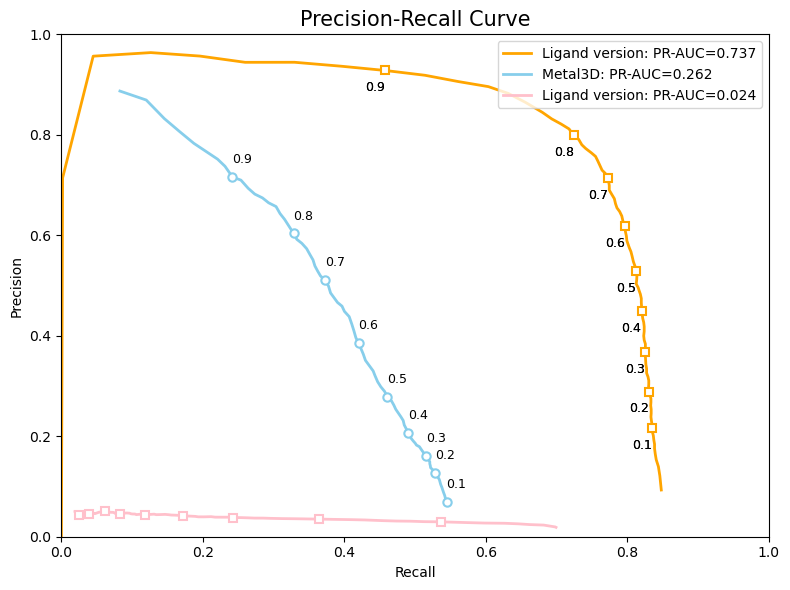

In [23]:
metal3d_auc = compute_prauc(metal3d_recall_list, metal3d_precision_list)
ligand_auc = compute_prauc(ligand_recall_list[2:], ligand_precision_list[2:])
biometall_auc = compute_prauc(biometall_recall_list, biometall_precision_list)
# ──────────────── Plot ────────────────
plt.figure(figsize=(8, 6))
# Ligand version
plt.plot(ligand_recall_list, ligand_precision_list, color='orange', linewidth=2,
         label=f"Ligand version: PR-AUC={ligand_auc:.3f}")
for i in range(len(thresholds)):
    if i % 10 == 0 and i != 0:
        plt.plot(ligand_recall_list[i], ligand_precision_list[i], marker='s',
                 markersize=6, markerfacecolor='white', markeredgecolor='orange', markeredgewidth=1.5)
        plt.annotate(f"{thresholds[i]:.1f}", (ligand_recall_list[i], ligand_precision_list[i]),
                     textcoords="offset points", xytext=(0, -15), ha='right', fontsize=9)

# Metal3D
plt.plot(metal3d_recall_list, metal3d_precision_list, color='skyblue', linewidth=2,
         label=f"Metal3D: PR-AUC={metal3d_auc:.3f}")
for i in range(len(thresholds)):
    if i % 10 == 0 and i != 0:
        plt.plot(metal3d_recall_list[i], metal3d_precision_list[i], marker='o',
                 markersize=6, markerfacecolor='white', markeredgecolor='skyblue', markeredgewidth=1.5)
        plt.annotate(f"{thresholds[i]:.1f}", (metal3d_recall_list[i], metal3d_precision_list[i]),
                     textcoords="offset points", xytext=(0, 10), ha='left', fontsize=9)


# Biometall
plt.plot(biometall_recall_list, biometall_precision_list, color='pink', linewidth=2,
         label=f"Ligand version: PR-AUC={biometall_auc:.3f}")
for i in range(len(thresholds)):
    if i % 10 == 0 and i != 0:
        plt.plot(biometall_recall_list[i], biometall_precision_list[i], marker='s',
                 markersize=6, markerfacecolor='white', markeredgecolor='pink', markeredgewidth=1.5)
        plt.annotate(f"{thresholds[i]:.1f}", (ligand_recall_list[i], ligand_precision_list[i]),
                     textcoords="offset points", xytext=(0, -15), ha='right', fontsize=9)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve",fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

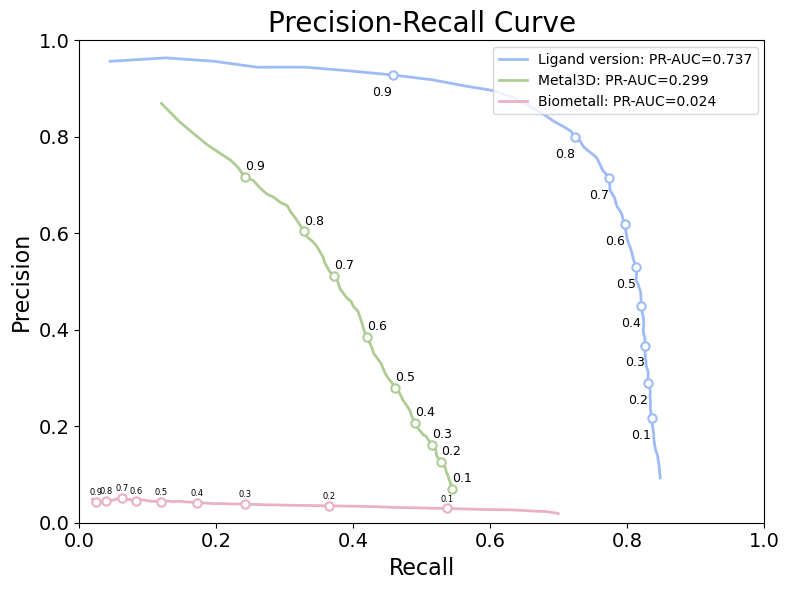

In [51]:
metal3d_auc = compute_prauc(metal3d_recall_list, metal3d_precision_list)
ligand_auc = compute_prauc(ligand_recall_list, ligand_precision_list)
biometall_auc = compute_prauc(biometall_recall_list, biometall_precision_list)
# ──────────────── Plot ────────────────
plt.figure(figsize=(8, 6))
# Ligand version
plt.plot(ligand_recall_list[:-3], ligand_precision_list[:-3], color='#9EBBF7', linewidth=2,
         label=f"Ligand version: PR-AUC={ligand_auc:.3f}")
for i in range(len(thresholds)):
    if i % 10 == 0 and i != 0:
        plt.plot(ligand_recall_list[i], ligand_precision_list[i], marker='o',
                 markersize=6, markerfacecolor='white', markeredgecolor='#9EBBF7', markeredgewidth=1.5)
        plt.annotate(f"{thresholds[i]:.1f}", (ligand_recall_list[i], ligand_precision_list[i]),
                     textcoords="offset points", xytext=(0, -15), ha='right', fontsize=9)

# Metal3D
plt.plot(metal3d_recall_list[:-2], metal3d_precision_list[:-2], color='#B0CC95', linewidth=2,
         label=f"Metal3D: PR-AUC={metal3d_auc:.3f}")
for i in range(len(thresholds)):
    if i % 10 == 0 and i != 0:
        plt.plot(metal3d_recall_list[i], metal3d_precision_list[i], marker='o',
                 markersize=6, markerfacecolor='white', markeredgecolor='#B0CC95', markeredgewidth=1.5)
        plt.annotate(f"{thresholds[i]:.1f}", (metal3d_recall_list[i], metal3d_precision_list[i]),
                     textcoords="offset points", xytext=(0, 5), ha='left', fontsize=9)


# Biometall
plt.plot(biometall_recall_list[:-2], biometall_precision_list[:-2], color='#EAB0C4', linewidth=2,
         label=f"Biometall: PR-AUC={biometall_auc:.3f}")
for i in range(len(thresholds)):
    if i % 10 == 0 and i != 0:
        plt.plot(biometall_recall_list[i], biometall_precision_list[i], marker='o',
                 markersize=6, markerfacecolor='white', markeredgecolor='#EAB0C4', markeredgewidth=1.5)
        plt.annotate(f"{thresholds[i]:.1f}", (biometall_recall_list[i], biometall_precision_list[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=6)

plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision-Recall Curve",fontsize=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

type 별 metalsite prcurve

In [24]:
import os
import numpy as np
from collections import defaultdict

# 입력 경로
pdb_list_file = "/home/qkrgangeun/LigMet/data/biolip/pdb/test_pdb_noerror.txt"
label_dir = "/home/qkrgangeun/LigMet/data/biolip/metal_label"

# 출력 경로
output_dir = "metal_testsets"
os.makedirs(output_dir, exist_ok=True)

# 초기화
metal_to_pdbs = defaultdict(list)

with open(pdb_list_file, "r") as f:
    pdb_ids = [line.strip().lower() for line in f if line.strip()]

for pdb_id in pdb_ids:
    label_path = os.path.join(label_dir, f"{pdb_id}.npz")
    if not os.path.exists(label_path):
        continue

    data = np.load(label_path)
    if "metal_types" not in data:
        continue
    metal_types = data["metal_types"]
    unique_types = set(metal_types)

    if len(unique_types) == 1:
        metal = list(unique_types)[0]
        metal_to_pdbs[metal].append(pdb_id)

# 파일 저장
for metal, pdb_list in metal_to_pdbs.items():
    with open(os.path.join(output_dir, f"{metal}_testset.txt"), "w") as f:
        for pdb_id in sorted(pdb_list):
            f.write(pdb_id + "\n")
    print(f"✅ {metal}: {len(pdb_list)} PDBs → saved to {metal}_testset.txt")


✅ MG: 198 PDBs → saved to MG_testset.txt
✅ CA: 183 PDBs → saved to CA_testset.txt
✅ ZN: 397 PDBs → saved to ZN_testset.txt
✅ CU: 7 PDBs → saved to CU_testset.txt
✅ MN: 39 PDBs → saved to MN_testset.txt
✅ FE: 38 PDBs → saved to FE_testset.txt
✅ CO: 2 PDBs → saved to CO_testset.txt
✅ NI: 1 PDBs → saved to NI_testset.txt


In [27]:
def evaluate_model_on_testset(testset_file, model_name="metal3d"):
    label_dir = "/home/qkrgangeun/LigMet/data/biolip/metal_label"
    if model_name == "metal3d":
        prediction_dir = "/home/qkrgangeun/metal-site-prediction/Metal3D/result"
    elif model_name == "biometall":
        prediction_dir = "/home/qkrgangeun/LigMet/benchmark/biometall/test_pdb_noerror"
    elif model_name == "ligand":
        prediction_dir = "/home/qkrgangeun/LigMet/data/biolip/test/0526"
    else:
        raise ValueError("Unknown model")

    thresholds = np.linspace(0.05, 0.95, 91)
    precision_list = []
    recall_list = []
    distance_threshold = 2.0

    with open(testset_file, "r") as f:
        pdb_ids = [line.strip().lower() for line in f if line.strip()]

    for threshold in thresholds:
        tp_total = fp_total = fn_total = 0

        for pdb_id in pdb_ids:
            label_path = os.path.join(label_dir, f"{pdb_id}.npz")
            if not os.path.exists(label_path):
                continue
            true_positions = np.load(label_path)["metal_positions"]

            if model_name == "metal3d":
                pred_path = os.path.join(prediction_dir, f"{pdb_id}.pdb")
                if not os.path.exists(pred_path):
                    continue
                pred_positions = []
                pred_scores = []
                with open(pred_path, "r") as f:
                    for line in f:
                        coord = [float(line[30:37]), float(line[37:45]), float(line[45:54])]
                        score = float(line[56:60])
                        pred_positions.append(coord)
                        pred_scores.append(score)

                if not pred_positions:
                    continue
                pred_positions = np.array(pred_positions)
                pred_scores = np.array(pred_scores)
                filtered = pred_positions[pred_scores >= threshold]

            elif model_name == "biometall":
                pred_path = os.path.join(prediction_dir, f"{pdb_id}.txt")
                if not os.path.exists(pred_path):
                    continue
                pred_positions = []
                pred_scores = []
                with open(pred_path, "r") as f:
                    lines = f.readlines()
                for line in lines:
                    if line.strip().endswith("|"):
                        parts = line.strip().split("|")
                        if len(parts) >= 4:
                            try:
                                coords = list(map(float, parts[2].strip().split()))
                                nprobe = int(parts[3].strip())
                                pred_positions.append(coords)
                                pred_scores.append(nprobe)
                            except:
                                continue
                if not pred_positions:
                    continue
                max_probe = max(pred_scores)
                pred_positions = np.array(pred_positions)
                pred_scores = np.array(pred_scores) / max_probe
                filtered = pred_positions[pred_scores >= threshold]

            elif model_name == "ligand":
                pred_path = os.path.join(prediction_dir, f"test_last_{pdb_id}.npz")
                if not os.path.exists(pred_path):
                    continue
                data = np.load(pred_path, allow_pickle=True)
                metal_positions = data["metal_positions"]
                grid_positions = data["grid_positions"]
                grid_predictions = data["pred"]
                num_grid = len(grid_positions) - len(metal_positions)
                mask = grid_predictions >= threshold
                mask2 = np.zeros_like(mask, dtype=bool)
                mask2[:num_grid] = True
                final_mask = mask & mask2
                selected_positions = grid_positions[final_mask]
                selected_preds = grid_predictions[final_mask]
                selected_positions, _ = dbscan_clustering(selected_positions, selected_preds)

                true_positions = metal_positions
                filtered = selected_positions

            tp, fp, fn = compute_precision_recall(filtered, true_positions, distance_threshold)
            tp_total += tp
            fp_total += fp
            fn_total += fn

        precision = tp_total / (tp_total + fp_total) if tp_total + fp_total > 0 else 0
        recall = tp_total / (tp_total + fn_total) if tp_total + fn_total > 0 else 0
        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list


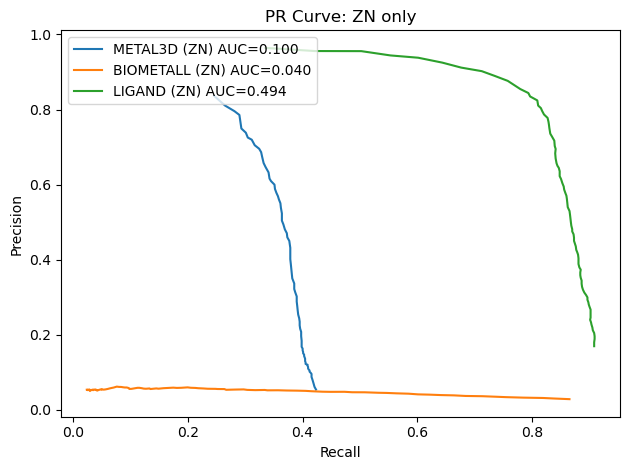

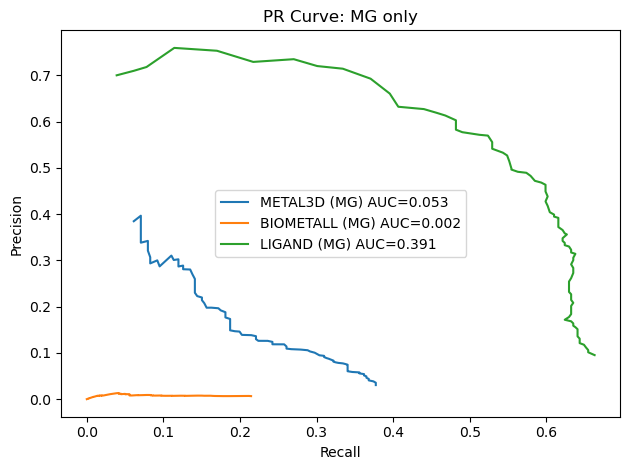

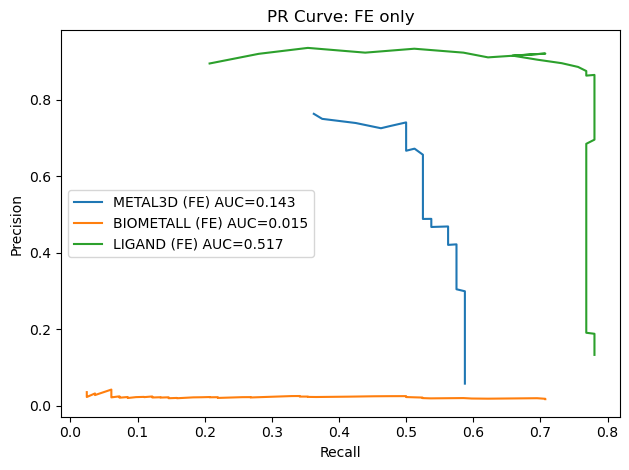

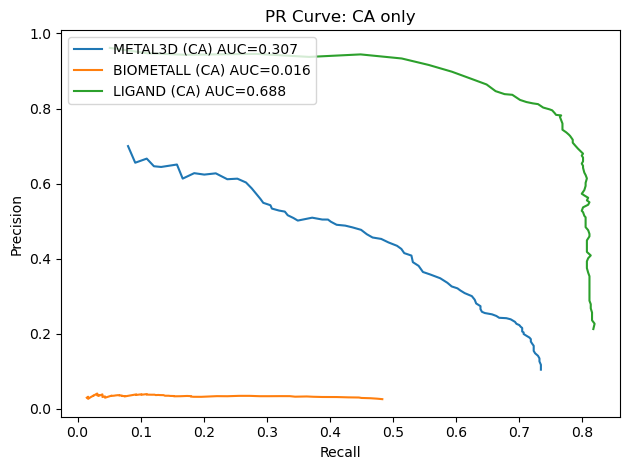

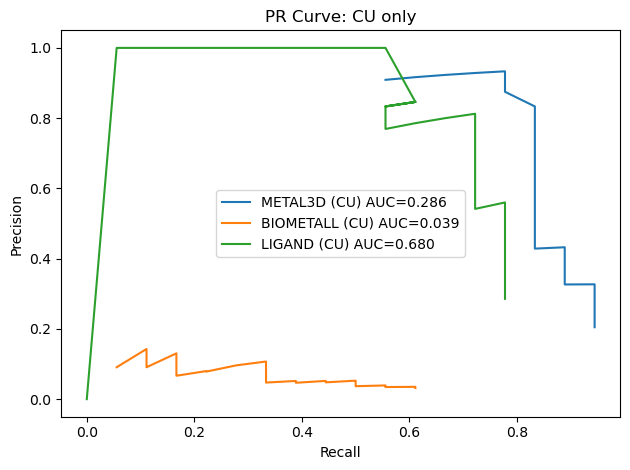

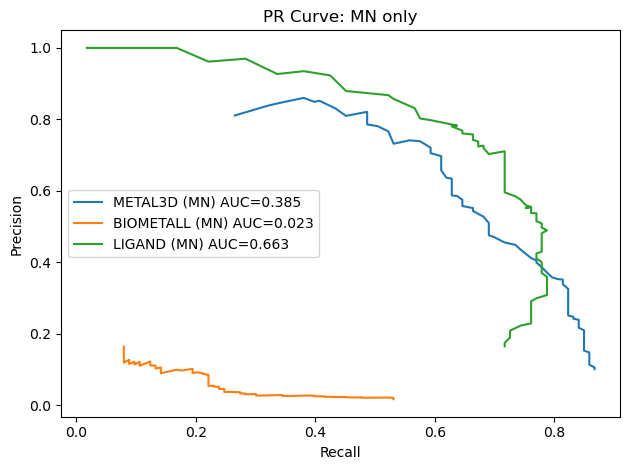

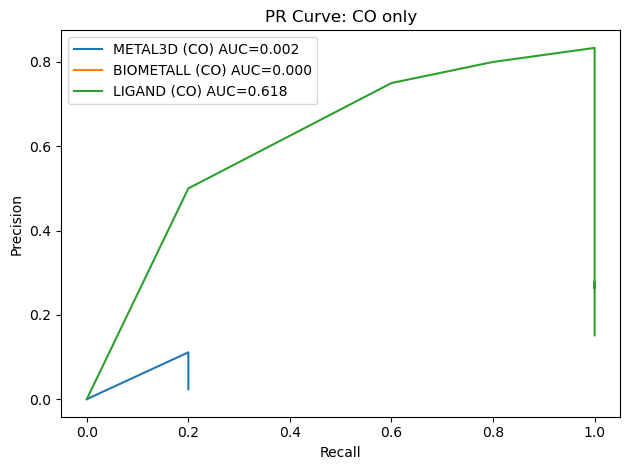

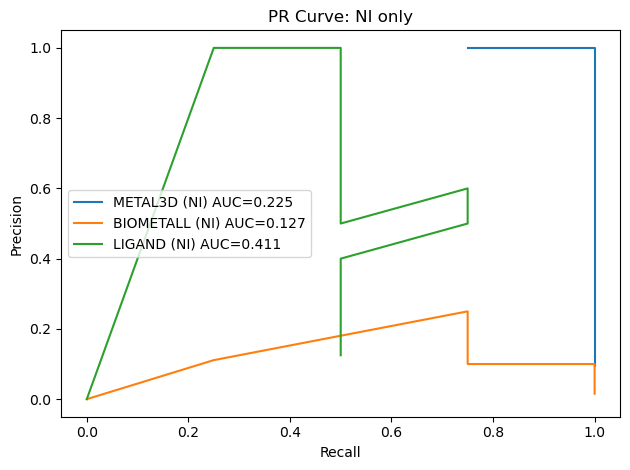

In [28]:
for metal in ["ZN", "MG", "FE", "CA","CU","MN","CO","NI"]:  # 필요한 금속만 선택
    testset_file = f"metal_testsets/{metal}_testset.txt"
    if not os.path.exists(testset_file):
        continue

    for model in ["metal3d", "biometall", "ligand"]:
        precision, recall = evaluate_model_on_testset(testset_file, model)
        auc_score = compute_prauc(recall, precision)
        plt.plot(recall, precision, label=f"{model.upper()} ({metal}) AUC={auc_score:.3f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve: {metal} only")
    plt.legend()
    plt.tight_layout()
    plt.show()


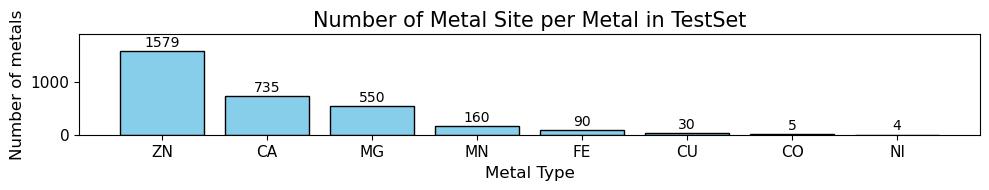

In [42]:
import matplotlib.pyplot as plt

# 데이터 입력
metal_types = ["ZN", "CA", "MG", "MN", "FE", "CU", "CO", "NI"]
counts = [1579, 735, 550, 160, 90, 30, 5, 4]

# 그래프 스타일
plt.figure(figsize=(10, 2))
bars = plt.bar(metal_types, counts, color='skyblue', edgecolor='black')

# 최대값 기반으로 y축 조정
max_count = max(counts)
plt.ylim(0, max_count * 1.2)  # 여유 10%

# 숫자 라벨 추가
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max_count * 0.02, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# 축 레이블 및 제목
plt.xlabel("Metal Type", fontsize=12)
plt.ylabel("Number of metals", fontsize=12)
plt.title("Number of Metal Site per Metal in TestSet", fontsize=15)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


Biometall